In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import sklearn.decomposition
import sklearn.linear_model
import matplotlib.pyplot as plt
import datetime
import dateutil
import gc

In [2]:
courses = pd.read_csv('course.csv')
courses

date  change_rate  delta_addictive  delta_mul
0     11.01.2007      26.4898           0.0433   1.001637
1     12.01.2007      26.5320           0.0422   1.001593
2     13.01.2007      26.5770           0.0450   1.001696
3     16.01.2007      26.5645          -0.0125   0.999530
4     17.01.2007      26.5481          -0.0164   0.999383
5     18.01.2007      26.5646           0.0165   1.000622
6     19.01.2007      26.5343          -0.0303   0.998859
7     20.01.2007      26.5075          -0.0268   0.998990
8     23.01.2007      26.5214           0.0139   1.000524
9     24.01.2007      26.5240           0.0026   1.000098
10    25.01.2007      26.4879          -0.0361   0.998639
11    26.01.2007      26.5018           0.0139   1.000525
12    27.01.2007      26.5575           0.0557   1.002102
13    30.01.2007      26.5747           0.0172   1.000648
14    31.01.2007      26.5331          -0.0416   0.998435
15    01.02.2007      26.5484           0.0153   1.000577
16    02.02.2007      26.4882          -0.0602   0.997732
17    03.02.2007      26.4800          -0.0082   0.999690
18    06.02.2007      26.5288           0.0488   1.001843
19    07.02.2007      26.5543           0.0255   1.000961
20    08.02.2007      26.5040          -0.0503   0.998106
21    09.02.2007      26.3945          -0.1095   0.995869
22    10.02.2007      26.3473          -0.0472   0.998212
23    13.02.2007      26.3414          -0.0059   0.999776
24    14.02.2007      26.3759           0.0345   1.001310
25    15.02.2007      26.3060          -0.0699   0.997350
26    16.02.2007      26.2314          -0.0746   0.997164
27    17.02.2007      26.2358           0.0044   1.000168
28    20.02.2007      26.2131          -0.0227   0.999135
29    21.02.2007      26.1964          -0.0167   0.999363
...          ...          ...              ...        ...
2737  23.01.2018      56.6261           0.0369   1.000652
2738  24.01.2018      56.4115          -0.2146   0.996210
2739  25.01.2018      56.3888          -0.0227   0.999598
2740  26.01.2018      55.9288          -0.4600   0.991842
2741  27.01.2018      55.8288          -0.1000   0.998212
2742  30.01.2018      56.2908           0.4620   1.008275
2743  31.01.2018      56.2914           0.0006   1.000011
2744  01.02.2018      56.1840          -0.1074   0.998092
2745  02.02.2018      56.2613           0.0773   1.001376
2746  03.02.2018      56.0408          -0.2205   0.996081
2747  06.02.2018      56.6278           0.5870   1.010475
2748  07.02.2018      57.2196           0.5918   1.010451
2749  08.02.2018      56.9533          -0.2663   0.995346
2750  09.02.2018      57.6736           0.7203   1.012647
2751  10.02.2018      58.1718           0.4982   1.008638
2752  13.02.2018      58.0171          -0.1547   0.997341
2753  14.02.2018      57.7701          -0.2470   0.995743
2754  15.02.2018      57.5899          -0.1802   0.996881
2755  16.02.2018      56.5918          -0.9981   0.982669
2756  17.02.2018      56.3554          -0.2364   0.995823
2757  20.02.2018      56.3438          -0.0116   0.999794
2758  21.02.2018      56.5201           0.1763   1.003129
2759  22.02.2018      56.6537           0.1336   1.002364
2760  23.02.2018      56.7608           0.1071   1.001890
2761  27.02.2018      55.9208          -0.8400   0.985201
2762  28.02.2018      55.6717          -0.2491   0.995545
2763  01.03.2018      56.3742           0.7025   1.012619
2764  02.03.2018      56.4334           0.0592   1.001050
2765  03.03.2018      56.6616           0.2282   1.004044
2766  06.03.2018      57.1000           0.4384   1.007737

[2767 rows x 4 columns]

In [3]:
courses_list = courses.to_dict('records')
for record in courses_list:
    record['date'] = dateutil.parser.parse(record['date'], dayfirst=True).date()

In [4]:
def get_ema(sequence,):
    alpha = 2 / (len(sequence) + 1)
    ema = 0
    for value in sequence:
        ema = (1 - alpha) * ema + alpha * value
    return ema

def get_ema_for_day(data, query_index, period, value_getter):
    first_date = data[query_index]['date'] + datetime.timedelta(days=-period)
    first_date_index = query_index
    while first_date_index > 0 and data[first_date_index - 1]['date'] >= first_date:
        first_date_index -= 1
    assert query_index + 1 - first_date_index <= period
    return get_ema([value_getter(d) for d in data[first_date_index:query_index + 1]])

In [5]:
def get_signal(yestarday, today):
    if (yestarday['macd'] - yestarday['macd_signal']) * (today['macd'] - today['macd_signal']) >= 0:
        return None
    if yestarday['macd'] - yestarday['macd_signal'] < 0:
        return 'Buy'
    return 'Sell'

for day_index, day_data in enumerate(courses_list):
    day_data['ema_12'] = get_ema_for_day(courses_list, day_index, 12, lambda d: d['change_rate'])
    day_data['ema_26'] = get_ema_for_day(courses_list, day_index, 26, lambda d: d['change_rate'])
    day_data['macd'] = day_data['ema_12'] - day_data['ema_26']
    day_data['macd_signal'] = get_ema_for_day(courses_list, day_index, 9, lambda d: d['macd'])
    if day_index > 0:
        day_data['vote'] = get_signal(courses_list[day_index - 1], day_data)
    else:
        day_data['vote'] = None

In [6]:
courses_macd = pd.DataFrame(courses_list)
courses_macd

change_rate        date  delta_addictive  delta_mul     ema_12  \
0         26.4898  2007-01-11           0.0433   1.001637  26.489800   
1         26.5320  2007-01-12           0.0422   1.001593  23.574622   
2         26.5770  2007-01-13           0.0450   1.001696  23.232725   
3         26.5645  2007-01-16          -0.0125   0.999530  23.113607   
4         26.5481  2007-01-17          -0.0164   0.999383  23.054551   
5         26.5646  2007-01-18           0.0165   1.000622  23.028058   
6         26.5343  2007-01-19          -0.0303   0.998859  23.004467   
7         26.5075  2007-01-20          -0.0268   0.998990  22.983738   
8         26.5214  2007-01-23           0.0139   1.000524  22.972920   
9         26.5240  2007-01-24           0.0026   1.000098  22.972056   
10        26.4879  2007-01-25          -0.0361   0.998639  22.963012   
11        26.5018  2007-01-26           0.0139   1.000525  22.957348   
12        26.5575  2007-01-27           0.0557   1.002102  22.959908   
13        26.5747  2007-01-30           0.0172   1.000648  22.973730   
14        26.5331  2007-01-31          -0.0416   0.998435  22.972516   
15        26.5484  2007-02-01           0.0153   1.000577  22.975418   
16        26.4882  2007-02-02          -0.0602   0.997732  22.966419   
17        26.4800  2007-02-03          -0.0082   0.999690  22.952377   
18        26.5288  2007-02-06           0.0488   1.001843  22.959527   
19        26.5543  2007-02-07           0.0255   1.000961  22.967453   
20        26.5040  2007-02-08          -0.0503   0.998106  22.963360   
21        26.3945  2007-02-09          -0.1095   0.995869  22.936690   
22        26.3473  2007-02-10          -0.0472   0.998212  22.905994   
23        26.3414  2007-02-13          -0.0059   0.999776  22.880400   
24        26.3759  2007-02-14           0.0345   1.001310  22.866847   
25        26.3060  2007-02-15          -0.0699   0.997350  22.843640   
26        26.2314  2007-02-16          -0.0746   0.997164  22.810375   
27        26.2358  2007-02-17           0.0044   1.000168  22.787790   
28        26.2131  2007-02-20          -0.0227   0.999135  22.756475   
29        26.1964  2007-02-21          -0.0167   0.999363  22.732999   
...           ...         ...              ...        ...        ...   
2737      56.6261  2018-01-23           0.0369   1.000652  49.018997   
2738      56.4115  2018-01-24          -0.2146   0.996210  48.970814   
2739      56.3888  2018-01-25          -0.0227   0.999598  48.924445   
2740      55.9288  2018-01-26          -0.4600   0.991842  48.805920   
2741      55.8288  2018-01-27          -0.1000   0.998212  48.701455   
2742      56.2908  2018-01-30           0.4620   1.008275  48.702653   
2743      56.2914  2018-01-31           0.0006   1.000011  48.701259   
2744      56.1840  2018-02-01          -0.1074   0.998092  48.674176   
2745      56.2613  2018-02-02           0.0773   1.001376  48.672546   
2746      56.0408  2018-02-03          -0.2205   0.996081  48.629064   
2747      56.6278  2018-02-06           0.5870   1.010475  48.712196   
2748      57.2196  2018-02-07           0.5918   1.010451  48.900002   
2749      56.9533  2018-02-08          -0.2663   0.995346  49.009334   
2750      57.6736  2018-02-09           0.7203   1.012647  49.243544   
2751      58.1718  2018-02-10           0.4982   1.008638  49.448865   
2752      58.0171  2018-02-13          -0.1547   0.997341  49.706880   
2753      57.7701  2018-02-14          -0.2470   0.995743  49.811346   
2754      57.5899  2018-02-15          -0.1802   0.996881  49.856804   
2755      56.5918  2018-02-16          -0.9981   0.982669  49.699470   
2756      56.3554  2018-02-17          -0.2364   0.995823  49.500559   
2757      56.3438  2018-02-20          -0.0116   0.999794  49.341235   
2758      56.5201  2018-02-21           0.1763   1.003129  49.248179   
2759      56.6537  2018-02-22           0.1336   1.002364  49.181120   
2760      56.7608  2018-02-23           0.1071

In [7]:
votes = courses_macd[['date', 'vote']]
votes.to_csv('macd.csv', index=False)

In [8]:
macd_strategy = {k:v['vote'] for k,v in votes.set_index('date').to_dict('index').items()}

In [9]:
macd_strategy

{datetime.date(2007, 1, 11): None,
 datetime.date(2007, 1, 12): None,
 datetime.date(2007, 1, 13): None,
 datetime.date(2007, 1, 16): None,
 datetime.date(2007, 1, 17): None,
 datetime.date(2007, 1, 18): None,
 datetime.date(2007, 1, 19): None,
 datetime.date(2007, 1, 20): None,
 datetime.date(2007, 1, 23): None,
 datetime.date(2007, 1, 24): None,
 datetime.date(2007, 1, 25): None,
 datetime.date(2007, 1, 26): None,
 datetime.date(2007, 1, 27): None,
 datetime.date(2007, 1, 30): None,
 datetime.date(2007, 1, 31): None,
 datetime.date(2007, 2, 1): None,
 datetime.date(2007, 2, 2): None,
 datetime.date(2007, 2, 3): 'Sell',
 datetime.date(2007, 2, 6): 'Buy',
 datetime.date(2007, 2, 7): None,
 datetime.date(2007, 2, 8): None,
 datetime.date(2007, 2, 9): 'Sell',
 datetime.date(2007, 2, 10): None,
 datetime.date(2007, 2, 13): None,
 datetime.date(2007, 2, 14): None,
 datetime.date(2007, 2, 15): None,
 datetime.date(2007, 2, 16): None,
 datetime.date(2007, 2, 17): None,
 datetime.date(2007, 2

## Get ML strategy

In [10]:
X_svd = sklearn.decomposition.TruncatedSVD(700).fit_transform(np.load('lemmas/bow_avg_lemmas.npy'))
gc.collect()
X_svd = sklearn.preprocessing.scale(X_svd, copy=False)

In [11]:
abs_deltas = courses.set_index('date').to_dict()['delta_addictive']
with open('lemmas/counted_days_lemmas.txt') as fl:
    dates = [dateutil.parser.parse(line[:line.find(' ')]).date() for line in fl]
y_all = np.array([1 if abs_deltas[x.strftime('%d.%m.%Y')] > 0 else -1 for x in dates])

In [79]:
def get_ml_predict(cls):
    ml_predictions = dict()
    start_day_index = len(dates) // 2
    for prediction_day_index in range(start_day_index, len(dates)):
        cls.fit(X_svd[:prediction_day_index], y_all[:prediction_day_index])
        ml_predictions[dates[prediction_day_index]] = cls.predict(X_svd[prediction_day_index].reshape(1, -1))[0]
        print("\rDone {:.2%} percents".format((prediction_day_index - start_day_index) / (len(dates) - start_day_index)), end='')
    return ml_predictions

ml_predictions = get_ml_predict(
    sklearn.linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-4, l1_ratio=0.2, tol=1e-4, random_state=42)
)

In [30]:
preds = np.squeeze(np.array([ml_predictions[k] for k in sorted(ml_predictions.keys())]))

In [31]:
(y_all[start_day_index:] == preds).sum() / len(preds)

0.5266331658291458

In [15]:
true_predict = {date:(1 if abs_deltas[date.strftime('%d.%m.%Y')] > 0 else -1) for date in dates}

In [16]:
sum(1 for date in ml_predictions if ml_predictions[date] == true_predict[date]) / len(ml_predictions)

0.5266331658291458

## Compare strategies

In [36]:
course_values = {datetime.datetime.strptime(k, '%d.%m.%Y').date():v for k, v in courses.set_index('date')['change_rate'].to_dict().items()}

class BaseStrategy:
    def __init__(self, start_pool):
        self.rub_money = start_pool
        self.dol_money = 0
    
    def rub2dol(self, money, course):
        assert money <= self.rub_money
        self.rub_money -= money
        self.dol_money += money / course
    
    def dol2rub(self, money, course):
        assert money <= self.dol_money
        self.dol_money -= money
        self.rub_money += money * course
    
    def total_rubles(self, date):
        return self.rub_money + self.dol_money * course_values[date]
    
    def total_dollars(self, date):
        return self.dol_money + self.rub_money / course_values[date]

class MACDStratery(BaseStrategy):
    def __init__(self, start_pool, macd_votes):
        super().__init__(start_pool)
        self.macd_votes = macd_votes
    
    def on_date(self, date):
        if self.macd_votes[date] == 'Buy':
            self.rub2dol(self.rub_money, course_values[date])
        elif self.macd_votes[date] == 'Sell':
            self.dol2rub(self.dol_money, course_values[date])

class NaiveMLStrategy(BaseStrategy):
    def __init__(self, start_pool, predicted_changes):
        super().__init__(start_pool)
        self.predicted_changes = predicted_changes
    
    def on_date(self, date):
        if self.predicted_changes[date] > 0:
            self.rub2dol(self.rub_money, course_values[date])
        else:
            self.dol2rub(self.dol_money, course_values[date])

def run_strategy(strategy, date_list):
    total_rubles, total_dollars = [], []
    for date in date_list:
        if date not in ml_predictions:
            continue
        strategy.on_date(date)
        total_rubles.append(strategy.total_rubles(date))
        total_dollars.append(strategy.total_dollars(date))
    return np.array(total_rubles), np.array(total_dollars)


In [37]:
start_pool = 100000
run_dates = dates[len(dates) // 2:]
run_results = {
    'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates),
    'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)
}

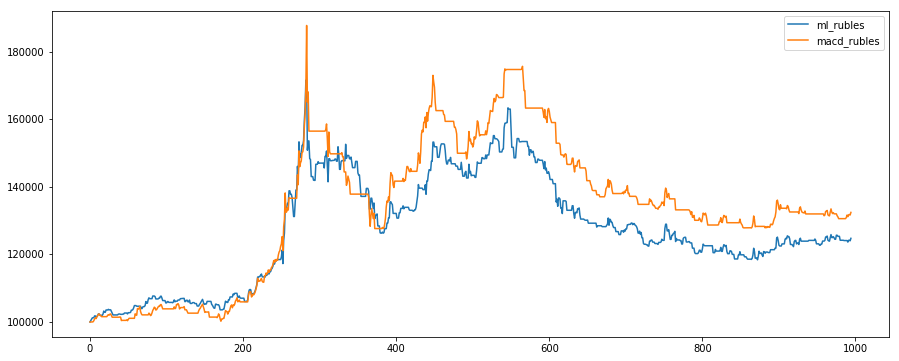

In [38]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][0])
plt.plot(run_results['macd'][0])
plt.legend(['ml_rubles', 'macd_rubles'])

plt.show()

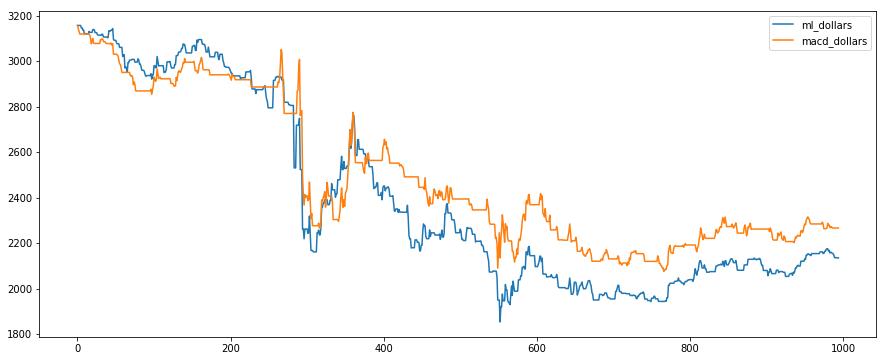

In [39]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][1])
plt.plot(run_results['macd'][1])
plt.legend(['ml_dollars', 'macd_dollars'])

plt.show()

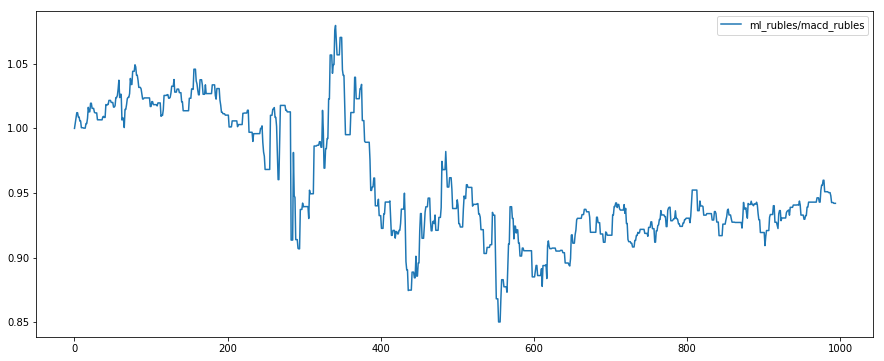

In [41]:
plt.figure(figsize=(15, 6))

plt.plot(run_results['ml'][0]/run_results['macd'][0])
plt.legend(['ml_rubles/macd_rubles'])

plt.show()

## Choose ML parameters

In [63]:
def get_cls_score_vs_macd(cls):
    ml_predictions = dict()
    start_day_index = len(dates) // 2
    run_dates = dates[len(dates) // 2:]
    for prediction_day_index in range(start_day_index, len(dates)):
        cls.fit(X_svd[:prediction_day_index], y_all[:prediction_day_index])
        ml_predictions[dates[prediction_day_index]] = cls.predict(X_svd[prediction_day_index].reshape(1, -1))[0]
    start_pool = 100000
    run_results = {
        'ml': run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates),
        'macd': run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)
    }
    return run_results['ml'][0] / run_results['macd'][0]

exp_range = [10**p for p in range(-5, 6)]
range_01 = [n / 10 for n in range(0, 11)]
sgd_params = {
    'loss': ['hinge', 'log'],
    'penalty': ['elasticnet'],
    'alpha': exp_range,
    'l1_ratio': range_01,
    'tol': [1e-4],
    'random_state': [42],
}

def get_all_params(params):
    import itertools
    return [{k:v for k, v in zip(params.keys(), values)} for values in itertools.product(*(params.values()))]

def _get_result_dict(map_params):
    cls, cls_params = map_params
    result_dict = cls_params.copy()
    result_dict['score_array'] = get_cls_score_vs_macd(cls)
    return result_dict

def run_grid_search(cls_type, params):
    import multiprocessing
    pool = multiprocessing.Pool(8)
    results = pool.imap_unordered(
        _get_result_dict,
        ((cls_type(**p), p) for p in params),
        10)
    pool.close()
    result_list = []
    for i, result in enumerate(results):
        result_list.append(result)
        print("\rDone {:.2%} percents".format((i + 1) / len(params)), end='')
    return result_list

In [64]:
cv_results = run_grid_search(sklearn.linear_model.SGDClassifier, get_all_params(sgd_params))

Done 4.13% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 20.66% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 83.47% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 100.00% percents

In [65]:
cv_results

[{'alpha': 10,
  'l1_ratio': 0.4,
  'loss': 'hinge',
  'penalty': 'elasticnet',
  'random_state': 42,
  'score_array': array([1.        , 1.        , 1.00416825, 1.00783983, 1.00783983,
         1.00783983, 1.00254064, 0.99944508, 1.00163038, 0.99647265,
         0.99647265, 0.99205638, 0.99172991, 0.99570443, 0.99590856,
         0.99590856, 0.99725414, 1.00128783, 1.00128783, 1.00128783,
         1.00128783, 1.00128783, 1.00128783, 1.00128783, 1.00128783,
         1.00259879, 1.00259879, 1.00208036, 1.00208036, 1.00208036,
         0.9968132 , 0.9968132 , 0.99519263, 0.99580984, 0.99929119,
         0.99927598, 0.99927598, 1.00158075, 1.00195474, 1.00195474,
         1.00195474, 1.01184887, 1.01121974, 1.01121974, 1.00989501,
         1.01302112, 1.01302112, 1.01302112, 1.01302112, 1.0156454 ,
         1.01203366, 1.01203366, 1.01203366, 1.01203366, 1.01203366,
         1.01203366, 1.01361084, 1.01361084, 1.02035963, 1.02035963,
         1.02284385, 1.02466976, 1.00485656, 1.00670746

In [69]:
# by last value
cv_by_last_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'][-1]} for r in cv_results]).sort_values('score', ascending=False)
cv_by_last_value

alpha  l1_ratio   loss     score
54        0.10000       1.0  hinge  1.447737
115       0.10000       1.0    log  1.324348
113       0.10000       0.8    log  1.295039
145       0.00010       0.3    log  1.290099
112       0.10000       0.7    log  1.286729
221       0.10000       0.5  hinge  1.282426
114       0.10000       0.9    log  1.264066
53        0.10000       0.9  hinge  1.257677
52        0.10000       0.8  hinge  1.239307
111       0.10000       0.6    log  1.234062
110       0.10000       0.5    log  1.220886
58        1.00000       0.3  hinge  1.218929
230       0.10000       0.3    log  1.218093
102       0.00001       0.1    log  1.214992
220       0.10000       0.4  hinge  1.205462
90        0.00010       0.9  hinge  1.186472
209       0.00100       0.4    log  1.172419
191   10000.00000       0.9    log  1.134438
190   10000.00000       0.8    log  1.134438
189   10000.00000       0.7    log  1.134438
188   10000.00000       0.6    log  1.134438
187   10000.00000       0.5    log  1.134438
1        10.00000       0.5  hinge  1.134438
0        10.00000       0.4  hinge  1.134438
192   10000.00000       1.0    log  1.134438
185   10000.00000       0.3    log  1.134438
193  100000.00000       0.0    log  1.134438
194  100000.00000       0.1    log  1.134438
195  100000.00000       0.2    log  1.134438
196  100000.00000       0.3    log  1.134438
..            ...       ...    ...       ...
210       0.00100       0.5    log  0.954218
207       0.00100       0.2    log  0.953556
239       0.01000       0.3    log  0.950491
107       0.00001       0.6    log  0.946471
144       0.00010       0.2    log  0.942062
160       1.00000       0.4    log  0.940537
143       0.00010       0.1    log  0.938065
123       0.01000       0.0  hinge  0.932743
165       1.00000       0.9    log  0.924388
60        0.00001       0.0  hinge  0.922544
140       0.00001       0.9    log  0.921808
62        0.00001       0.2  hinge  0.920926
213       0.01000       0.8  hinge  0.914709
237       0.01000       0.1    log  0.910820
125       0.01000       0.2  hinge  0.903022
234       0.00100       0.9    log  0.896363
232       0.00100       0.7    log  0.894092
129       0.01000       0.6  hinge  0.887934
126       0.01000       0.3  hinge  0.871601
235       0.00100       1.0    log  0.865924
119       1.00000       0.3    log  0.864392
166       1.00000       1.0    log  0.864141
55        1.00000       0.0  hinge  0.861546
80        0.00001       1.0  hinge  0.840560
223       0.01000       0.7    log  0.838858
127       0.01000       0.4  hinge  0.831166
116       1.00000       0.0    log  0.815933
227       0.10000       0.0    log  0.797074
124       0.01000       0.1  hinge  0.743106
216       0.10000       0.0  hinge  0.728988

[242 rows x 4 columns]

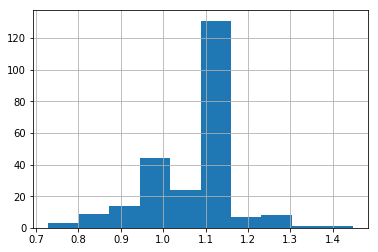

In [72]:
cv_by_last_value['score'].hist()

In [73]:
cv_by_avg_value = pd.DataFrame([{'loss': r['loss'], 'alpha': r['alpha'], 'l1_ratio': r['l1_ratio'],
               'score':r['score_array'].mean()} for r in cv_results]).sort_values('score', ascending=False)
cv_by_avg_value

alpha  l1_ratio   loss     score
54   0.10000       1.0  hinge  1.244427
115  0.10000       1.0    log  1.242635
113  0.10000       0.8    log  1.201678
114  0.10000       0.9    log  1.194750
112  0.10000       0.7    log  1.192059
220  0.10000       0.4  hinge  1.189601
221  0.10000       0.5  hinge  1.148339
111  0.10000       0.6    log  1.146463
145  0.00010       0.3    log  1.139009
53   0.10000       0.9  hinge  1.138586
110  0.10000       0.5    log  1.133282
52   0.10000       0.8  hinge  1.127366
102  0.00001       0.1    log  1.106274
219  0.10000       0.3  hinge  1.097369
217  0.10000       0.1  hinge  1.090127
209  0.00100       0.4    log  1.087134
58   1.00000       0.3  hinge  1.084833
230  0.10000       0.3    log  1.083782
240  0.01000       0.4    log  1.082736
228  0.10000       0.1    log  1.079182
224  0.01000       0.8    log  1.074159
90   0.00010       0.9  hinge  1.071136
122  0.00100       1.0  hinge  1.068685
98   0.00100       0.6  hinge  1.051187
87   0.00010       0.6  hinge  1.045077
65   0.00001       0.5  hinge  1.044415
147  0.00010       0.5    log  1.042832
225  0.01000       0.9    log  1.042127
67   0.00001       0.7  hinge  1.041506
85   0.00010       0.4  hinge  1.041320
..       ...       ...    ...       ...
107  0.00001       0.6    log  0.948611
126  0.01000       0.3  hinge  0.947516
210  0.00100       0.5    log  0.946384
56   1.00000       0.1  hinge  0.946227
24   1.00000       0.9  hinge  0.944961
141  0.00001       1.0    log  0.942488
118  1.00000       0.2    log  0.939992
205  0.00100       0.0    log  0.939776
237  0.01000       0.1    log  0.937693
162  1.00000       0.6    log  0.937337
25   1.00000       1.0  hinge  0.936148
143  0.00010       0.1    log  0.933035
123  0.01000       0.0  hinge  0.932098
208  0.00100       0.3    log  0.931361
234  0.00100       0.9    log  0.930933
62   0.00001       0.2  hinge  0.929791
235  0.00100       1.0    log  0.928967
104  0.00001       0.3    log  0.925493
127  0.01000       0.4  hinge  0.924688
232  0.00100       0.7    log  0.914933
165  1.00000       0.9    log  0.912520
55   1.00000       0.0  hinge  0.907241
160  1.00000       0.4    log  0.907037
227  0.10000       0.0    log  0.905878
80   0.00001       1.0  hinge  0.902835
166  1.00000       1.0    log  0.886376
116  1.00000       0.0    log  0.881435
119  1.00000       0.3    log  0.870059
124  0.01000       0.1  hinge  0.842089
216  0.10000       0.0  hinge  0.826985

[242 rows x 4 columns]

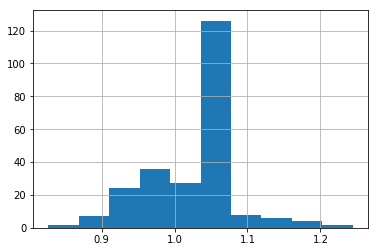

In [75]:
cv_by_avg_value['score'].hist()

### Run best ML strategy

In [80]:
ml_predictions = get_ml_predict(sklearn.linear_model.SGDClassifier(alpha=0.1, loss='hinge', penalty='l1', tol=1e-4))
best_ml_results = run_strategy(NaiveMLStrategy(start_pool, ml_predictions), run_dates)[0] /\
    run_strategy(MACDStratery(start_pool, macd_strategy), run_dates)[0]

Done 6.03% percents

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Done 99.90% percents

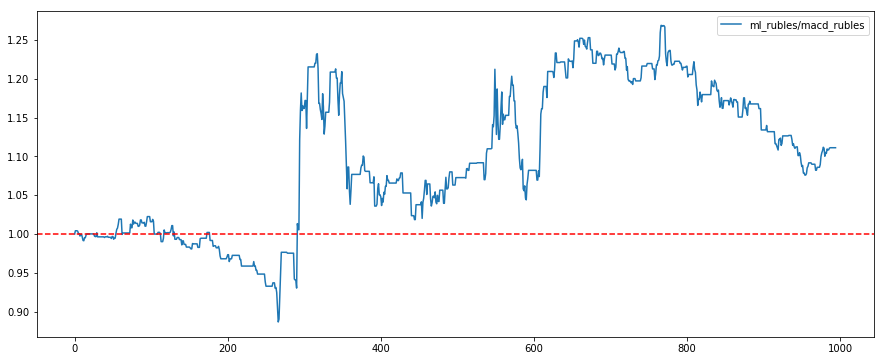

In [85]:
plt.figure(figsize=(15, 6))

plt.plot(best_ml_results)
plt.axhline(1, C='red', linestyle='--')
plt.legend(['ml_rubles/macd_rubles'])

plt.show()